In [1]:
import numpy as np

np.log2(1/32)

np.float64(-5.0)

In [2]:
# 有32支球队，其中一支（比如队A）得到冠军的概率为1/2，其余31支球队概率均等，总和也为1/2
# 概率分布为：[1/2, 1/62, 1/62, ..., 1/62] (31 个 1/62)
p_A = 1/2
p_others = 1/2 / 31  # 每一队的概率
# 构造概率列表
probs = [p_A] + [p_others]*31
# 计算熵
entropy = -sum([p * np.log2(p) for p in probs])
entropy


np.float64(3.4770981551934397)

In [3]:
import pandas as pd

# 读取数据，只取指定的列
df = pd.read_csv("data/titanic.csv", usecols=["pclass", "sex", "age", "survived"])

# 展示前几行数据
display(df.head())

# 检查各列是否有空值
print(df.isnull().sum())

print(df.describe(include='all'))


,pclass,survived,age,sex
0,1st,1,29.0000,female
1,1st,0,2.0000,female
2,1st,0,30.0000,male
3,1st,0,25.0000,female
4,1st,1,0.9167,male


pclass        0
survived      0
age         680
sex           0
dtype: int64
       pclass     survived         age   sex
count    1313  1313.000000  633.000000  1313
unique      3          NaN         NaN     2
top       3rd          NaN         NaN  male
freq      711          NaN         NaN   850
mean      NaN     0.341965   31.194181   NaN
std       NaN     0.474549   14.747525   NaN
min       NaN     0.000000    0.166700   NaN
25%       NaN     0.000000   21.000000   NaN
50%       NaN     0.000000   30.000000   NaN
75%       NaN     1.000000   41.000000   NaN
max       NaN     1.000000   71.000000   NaN


In [4]:
#预处理
# 针对age缺失的，填充为均值
df['age'] = df['age'].fillna(df['age'].mean())

# 取出survived作为标签
y = df['survived']

# pclass和sex取出来作为one-hot编码，age放入X中
X = pd.get_dummies(df[['pclass', 'sex']])
X['age'] = df['age']

# X现在是one-hot形式的特征并包含age，y是目标标签
X

,pclass_1st,pclass_2nd,pclass_3rd,sex_female,sex_male,age
0,True,False,False,True,False,29.000000
1,True,False,False,True,False,2.000000
2,True,False,False,False,True,30.000000
3,True,False,False,True,False,25.000000
4,True,False,False,False,True,0.916700
...,...,...,...,...,...,...
1308,False,False,True,False,True,31.194181
1309,False,False,True,False,True,31.194181
1310,False,False,True,False,True,31.194181
1311,False,False,True,True,False,31.194181


准确率: 0.8365019011406845


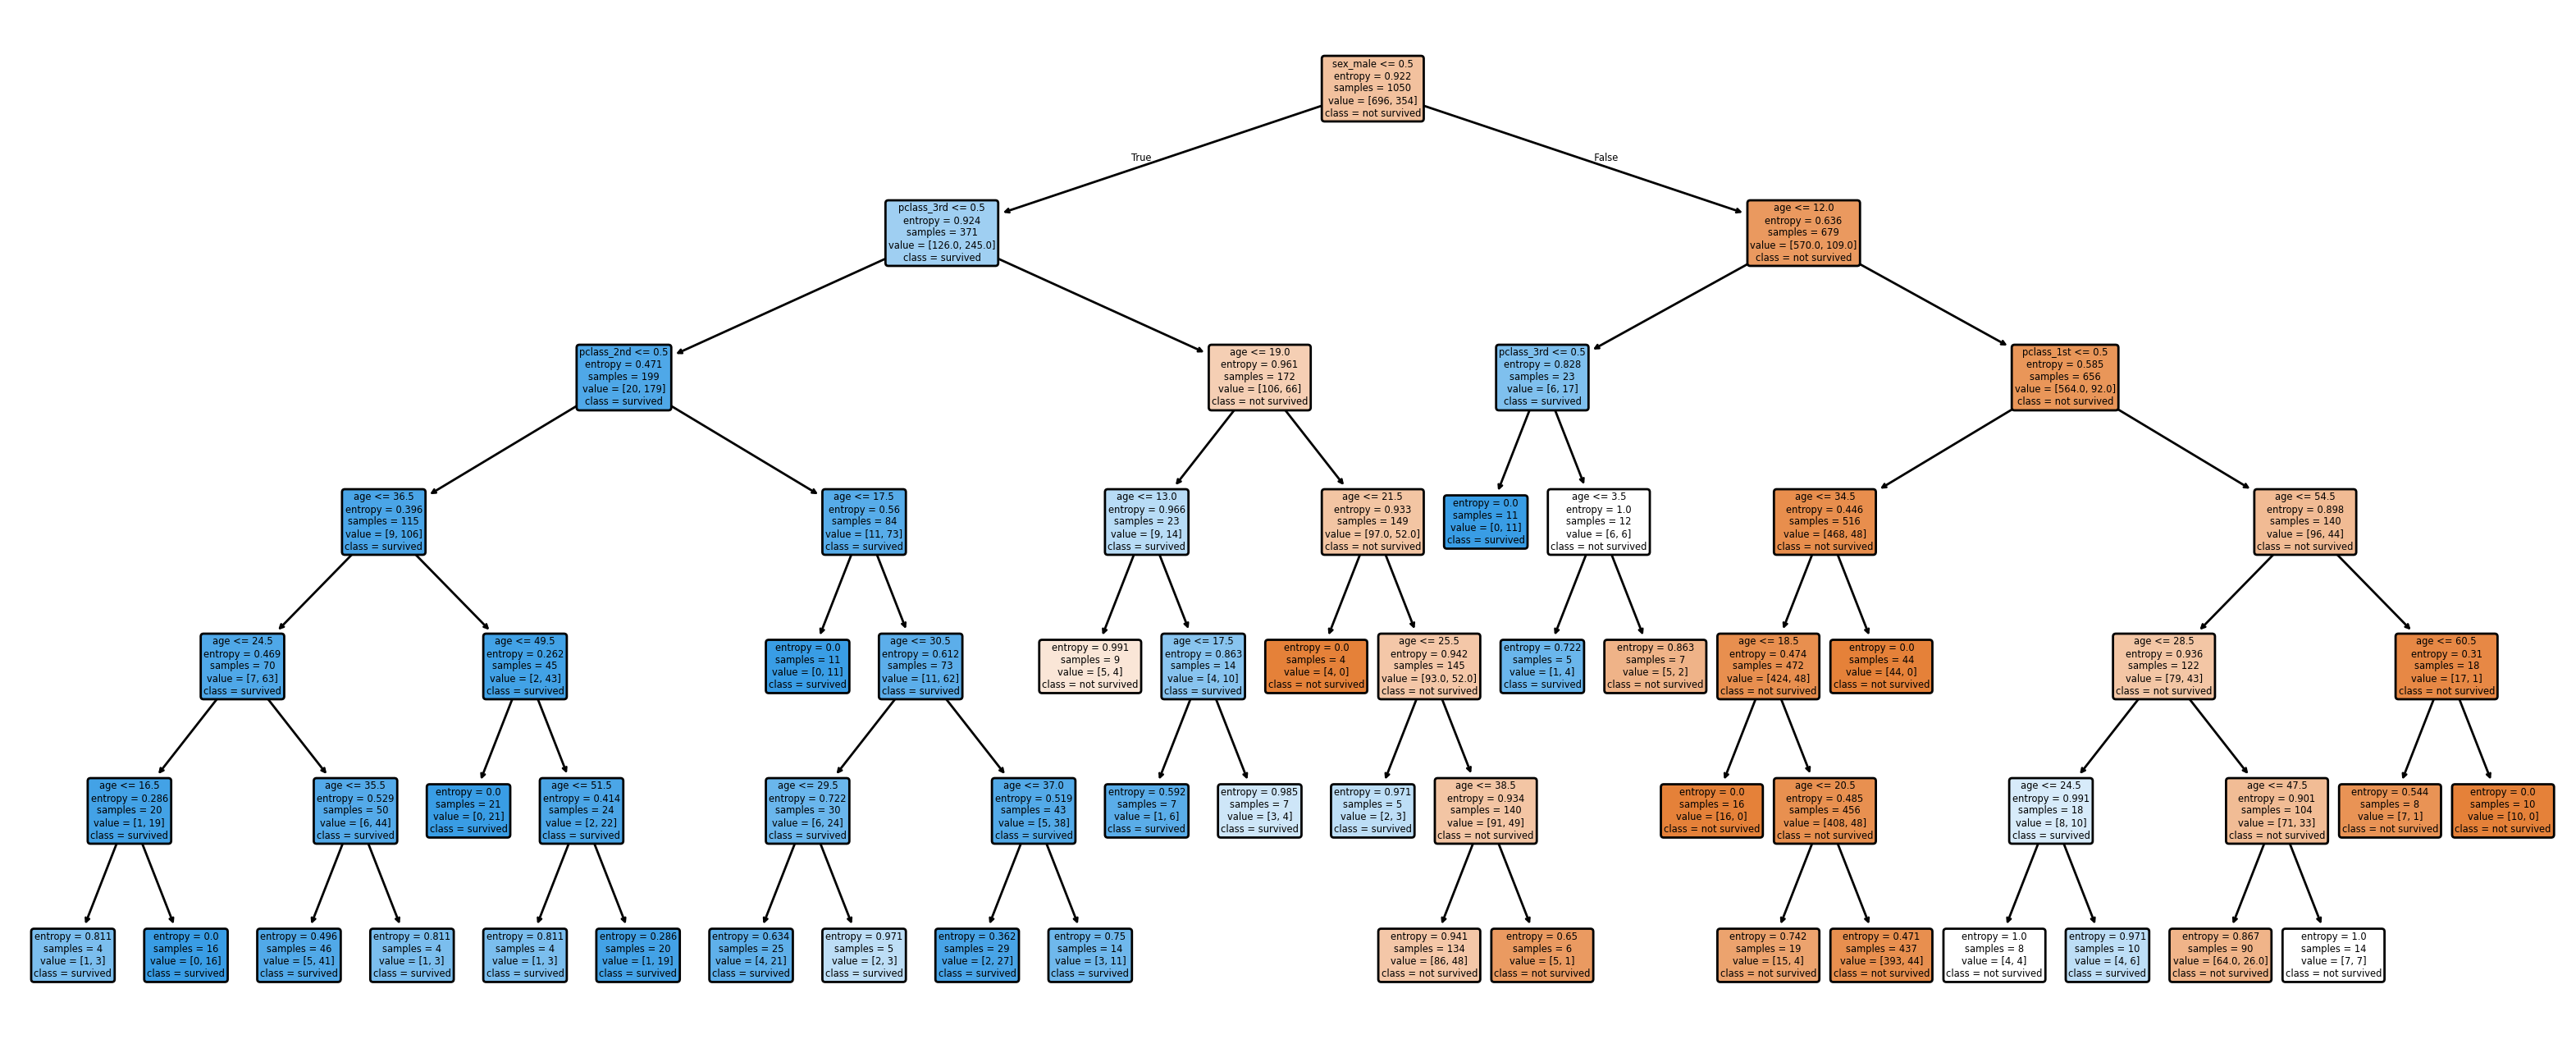

In [5]:
#训练模型
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

# 划分训练集与测试集，比例0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 用决策树进行训练
clf = DecisionTreeClassifier(
    random_state=42,         # 随机种子，保证结果可复现
    max_depth=6,             # 树的最大深度，防止过拟合
    min_samples_split=10,    # 内部节点再划分所需最小样本数
    min_samples_leaf=4,      # 叶子节点最少样本数，避免出现只含一个样本的叶子
    criterion='entropy'      # 划分标准，这里用信息增益（熵）
)
clf.fit(X_train, y_train)

# 评估模型
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("准确率:", acc)

# 可视化决策树，增加dpi
plt.figure(figsize=(20,8), dpi=200)
tree.plot_tree(clf, 
               feature_names=X.columns, 
               class_names=["not survived", "survived"],
               filled=True,
               rounded=True)
plt.savefig('titanic.svg')


In [6]:
# 统计y_train中0和1的数量
print("训练集中未存活(0)人数:", (y_train == 0).sum())
print("训练集中存活(1)人数:", (y_train == 1).sum())

# 用groupby分析性别与存活的对应关系
# 先还原sex标签
sex_train = df.loc[X_train.index, 'sex']
survived_train = y_train

sex_survived = pd.DataFrame({
    'sex': sex_train,
    'survived': survived_train
})

grouped = sex_survived.groupby(['sex', 'survived']).size().unstack(fill_value=0)
print("\n按性别分组的存活情况：")
print(grouped)



训练集中未存活(0)人数: 696
训练集中存活(1)人数: 354

按性别分组的存活情况：
survived    0    1
sex               
female    126  245
male      570  109


# 随机森林

In [7]:
from sklearn.ensemble import RandomForestClassifier

# 创建随机森林分类器
rf_clf = RandomForestClassifier(
    n_estimators=500,    # 默认100棵树
    criterion='entropy', # 和上面决策树保持一致
    max_depth=5,
    random_state=42
)
rf_clf.fit(X_train, y_train)

# 预测并评估
rf_y_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_y_pred)
print("随机森林准确率:", rf_acc)


随机森林准确率: 0.8365019011406845


In [ ]:
# 针对泰坦尼克号数据，设计一个更适合的网格搜索超参数集合（可适当缩小范围以便加速，也兼容典型特征数量/特性）
param_grid = {
    'n_estimators': [100, 200, 300],        # 森林中树的数量
    'max_depth': [3, 5, 7, None],           # 树的最大深度，None表示不限制
    'criterion': ['gini', 'entropy'],       # 划分标准
    'max_features': ['sqrt', 'log2', None], # 每棵树最大特征数，常用sqrt(特征数)、log2(特征数)和全部特征
    'min_samples_split': [2, 5, 10],        # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4],          # 叶子节点最少样本数
    'random_state': [42]                    # 保证可复现
}

from sklearn.model_selection import GridSearchCV

# 定义网格搜索对象，对随机森林分类器进行超参数搜索
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# 在训练集上训练
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳分数
print("最佳参数:", grid_search.best_params_)
print("最佳准确率: {:.4f}".format(grid_search.best_score_))

# 输出最佳max_features对应的特征数
best_max_features = grid_search.best_params_['max_features']
if best_max_features is None or best_max_features == 'auto':
    n_features_used = X_train.shape[1]
elif best_max_features == 'sqrt':
    import math
    n_features_used = int(math.sqrt(X_train.shape[1]))
elif best_max_features == 'log2':
    import math
    n_features_used = int(math.log2(X_train.shape[1]))
else:
    n_features_used = best_max_features

print(f"最优模型使用的特征数: {n_features_used}")

# 在测试集上评估最优模型
best_rf = grid_search.best_estimator_
test_acc = best_rf.score(X_test, y_test)
print("最优模型在测试集上的准确率: {:.4f}".format(test_acc))
